In [1]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

bs = 100
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## CVAE Model

In [3]:
class CVAE(nn.Module):
    def __init__(self, x_dim, h_dim, z_dim, cls_dim):
        super(CVAE, self).__init__()

        # Encoder
        self.fc1 = nn.Linear(x_dim + cls_dim, h_dim)
        self.fc2_mu = nn.Linear(h_dim, z_dim)
        self.fc2_logvar = nn.Linear(h_dim, z_dim)

        # Decoder
        self.fc3 = nn.Linear(z_dim + cls_dim, h_dim)
        self.fc4 = nn.Linear(h_dim, x_dim)

    def encoder(self, x, cls):
        concat_input = torch.cat([x, cls], 1)
        h = F.relu(self.fc1(concat_input))
        return self.fc2_mu(h), self.fc2_logvar(h)

    def sampling(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def decoder(self, z, cls):
        concat_input = torch.cat([z, cls], 1)
        h = F.relu(self.fc3(concat_input))
        return F.sigmoid(self.fc4(h))

    def forward(self, x, cls):
        mu, logvar = self.encoder(x.view(-1,784), cls)
        z = self.sampling(mu, logvar)
        return self.decoder(z, cls), mu, logvar

In [4]:
cls_dim = 10 # 0부터 9까지
cvae = CVAE(x_dim=784, h_dim=400, z_dim=20, cls_dim=cls_dim).to(device)
print(cvae)

CVAE(
  (fc1): Linear(in_features=794, out_features=400, bias=True)
  (fc2_mu): Linear(in_features=400, out_features=20, bias=True)
  (fc2_logvar): Linear(in_features=400, out_features=20, bias=True)
  (fc3): Linear(in_features=30, out_features=400, bias=True)
  (fc4): Linear(in_features=400, out_features=784, bias=True)
)


In [5]:
optimizer = optim.Adam(cvae.parameters(), lr=0.001)

def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# 원핫 인코딩
def one_hot(labels, class_size=10):
    targets = torch.zeros(labels.size(0), class_size)
    for i, label in enumerate(labels):
        targets[i, label] = 1

    return Variable(targets)

## Training

In [6]:
from tqdm.notebook import tqdm

In [7]:
def train(epoch):
    cvae.train()
    train_loss = 0
    for batch_idx, (data, labels) in tqdm(enumerate(train_loader)):
        data = data.to(device)
        labels = one_hot(labels, cls_dim).to(device)
        optimizer.zero_grad()

        recon_batch, mu, logvar = cvae(data, labels)
        loss = loss_function(recon_batch, data, mu, logvar)

        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if batch_idx % 1000 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(
        epoch, train_loss / len(train_loader.dataset)))

In [8]:
def test():
    cvae.eval()
    test_loss = 0

    with torch.no_grad():
        for data, labels in test_loader:
            data = data.to(device)
            labels = one_hot(labels, cls_dim).to(device)
            recon_batch, mu, logvar = cvae(data, labels)

            test_loss += loss_function(recon_batch, data, mu, logvar).item()

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

## Train CVAE and Inference

In [10]:
for epoch in range(1, 51):
    train(epoch)
    test()

    with torch.no_grad():
        z = torch.randn(10, 20).to(device)
        cls = torch.eye(cls_dim).to(device)

        sample = cvae.decoder(z, cls).view(10, 1, 28, 28)
        save_image(sample, './results_CVAE/sample_' + str(epoch) + '.png')

0it [00:00, ?it/s]

Train Epoch: 1 [0/60000 (0%)]	Loss: 122.326260
====> Epoch: 1 Average loss: 116.4615
====> Test set loss: 111.5846


0it [00:00, ?it/s]

Train Epoch: 2 [0/60000 (0%)]	Loss: 115.461084
====> Epoch: 2 Average loss: 110.5730
====> Test set loss: 107.8346


0it [00:00, ?it/s]

Train Epoch: 3 [0/60000 (0%)]	Loss: 106.705166
====> Epoch: 3 Average loss: 107.7002
====> Test set loss: 105.8201


0it [00:00, ?it/s]

Train Epoch: 4 [0/60000 (0%)]	Loss: 104.564512
====> Epoch: 4 Average loss: 105.9197
====> Test set loss: 104.3715


0it [00:00, ?it/s]

Train Epoch: 5 [0/60000 (0%)]	Loss: 105.834199
====> Epoch: 5 Average loss: 104.6696
====> Test set loss: 103.8682


0it [00:00, ?it/s]

Train Epoch: 6 [0/60000 (0%)]	Loss: 106.175820
====> Epoch: 6 Average loss: 103.7620
====> Test set loss: 103.0601


0it [00:00, ?it/s]

Train Epoch: 7 [0/60000 (0%)]	Loss: 104.674707
====> Epoch: 7 Average loss: 103.0508
====> Test set loss: 102.2064


0it [00:00, ?it/s]

Train Epoch: 8 [0/60000 (0%)]	Loss: 100.185010
====> Epoch: 8 Average loss: 102.4936
====> Test set loss: 101.7307


0it [00:00, ?it/s]

Train Epoch: 9 [0/60000 (0%)]	Loss: 104.277031
====> Epoch: 9 Average loss: 101.9441
====> Test set loss: 101.5816


0it [00:00, ?it/s]

Train Epoch: 10 [0/60000 (0%)]	Loss: 102.781514
====> Epoch: 10 Average loss: 101.5907
====> Test set loss: 100.9566


0it [00:00, ?it/s]

Train Epoch: 11 [0/60000 (0%)]	Loss: 105.173574
====> Epoch: 11 Average loss: 101.1832
====> Test set loss: 100.7568


0it [00:00, ?it/s]

Train Epoch: 12 [0/60000 (0%)]	Loss: 99.115059
====> Epoch: 12 Average loss: 100.8697
====> Test set loss: 100.2892


0it [00:00, ?it/s]

Train Epoch: 13 [0/60000 (0%)]	Loss: 103.043555
====> Epoch: 13 Average loss: 100.5466
====> Test set loss: 100.2964


0it [00:00, ?it/s]

Train Epoch: 14 [0/60000 (0%)]	Loss: 94.571484
====> Epoch: 14 Average loss: 100.3558
====> Test set loss: 99.9211


0it [00:00, ?it/s]

Train Epoch: 15 [0/60000 (0%)]	Loss: 98.345850
====> Epoch: 15 Average loss: 100.0734
====> Test set loss: 99.8303


0it [00:00, ?it/s]

Train Epoch: 16 [0/60000 (0%)]	Loss: 97.633867
====> Epoch: 16 Average loss: 99.9009
====> Test set loss: 99.7640


0it [00:00, ?it/s]

Train Epoch: 17 [0/60000 (0%)]	Loss: 99.120049
====> Epoch: 17 Average loss: 99.6538
====> Test set loss: 99.5864


0it [00:00, ?it/s]

Train Epoch: 18 [0/60000 (0%)]	Loss: 105.439277
====> Epoch: 18 Average loss: 99.5478
====> Test set loss: 99.2749


0it [00:00, ?it/s]

Train Epoch: 19 [0/60000 (0%)]	Loss: 100.526172
====> Epoch: 19 Average loss: 99.3336
====> Test set loss: 99.0789


0it [00:00, ?it/s]

Train Epoch: 20 [0/60000 (0%)]	Loss: 96.827344
====> Epoch: 20 Average loss: 99.2320
====> Test set loss: 99.1886


0it [00:00, ?it/s]

Train Epoch: 21 [0/60000 (0%)]	Loss: 102.007686
====> Epoch: 21 Average loss: 99.0378
====> Test set loss: 98.9400


0it [00:00, ?it/s]

Train Epoch: 22 [0/60000 (0%)]	Loss: 97.723867
====> Epoch: 22 Average loss: 98.9124
====> Test set loss: 98.6553


0it [00:00, ?it/s]

Train Epoch: 23 [0/60000 (0%)]	Loss: 97.695293
====> Epoch: 23 Average loss: 98.8024
====> Test set loss: 98.6529


0it [00:00, ?it/s]

Train Epoch: 24 [0/60000 (0%)]	Loss: 99.186094
====> Epoch: 24 Average loss: 98.6590
====> Test set loss: 98.5976


0it [00:00, ?it/s]

Train Epoch: 25 [0/60000 (0%)]	Loss: 102.285127
====> Epoch: 25 Average loss: 98.5357
====> Test set loss: 98.5204


0it [00:00, ?it/s]

Train Epoch: 26 [0/60000 (0%)]	Loss: 97.349883
====> Epoch: 26 Average loss: 98.4225
====> Test set loss: 98.3294


0it [00:00, ?it/s]

Train Epoch: 27 [0/60000 (0%)]	Loss: 100.641934
====> Epoch: 27 Average loss: 98.3586
====> Test set loss: 98.3064


0it [00:00, ?it/s]

Train Epoch: 28 [0/60000 (0%)]	Loss: 101.119531
====> Epoch: 28 Average loss: 98.2625
====> Test set loss: 98.1377


0it [00:00, ?it/s]

Train Epoch: 29 [0/60000 (0%)]	Loss: 101.737920
====> Epoch: 29 Average loss: 98.1158
====> Test set loss: 98.1488


0it [00:00, ?it/s]

Train Epoch: 30 [0/60000 (0%)]	Loss: 97.948486
====> Epoch: 30 Average loss: 98.0693
====> Test set loss: 98.0957


0it [00:00, ?it/s]

Train Epoch: 31 [0/60000 (0%)]	Loss: 100.074727
====> Epoch: 31 Average loss: 97.9644
====> Test set loss: 97.8626


0it [00:00, ?it/s]

Train Epoch: 32 [0/60000 (0%)]	Loss: 100.705957
====> Epoch: 32 Average loss: 97.9212
====> Test set loss: 98.2671


0it [00:00, ?it/s]

Train Epoch: 33 [0/60000 (0%)]	Loss: 100.761680
====> Epoch: 33 Average loss: 97.8249
====> Test set loss: 97.9110


0it [00:00, ?it/s]

Train Epoch: 34 [0/60000 (0%)]	Loss: 96.129502
====> Epoch: 34 Average loss: 97.7681
====> Test set loss: 97.8568


0it [00:00, ?it/s]

Train Epoch: 35 [0/60000 (0%)]	Loss: 97.654102
====> Epoch: 35 Average loss: 97.6780
====> Test set loss: 97.5843


0it [00:00, ?it/s]

Train Epoch: 36 [0/60000 (0%)]	Loss: 97.493115
====> Epoch: 36 Average loss: 97.6224
====> Test set loss: 97.8639


0it [00:00, ?it/s]

Train Epoch: 37 [0/60000 (0%)]	Loss: 96.878730
====> Epoch: 37 Average loss: 97.5368
====> Test set loss: 97.6609


0it [00:00, ?it/s]

Train Epoch: 38 [0/60000 (0%)]	Loss: 94.302305
====> Epoch: 38 Average loss: 97.4980
====> Test set loss: 97.6807


0it [00:00, ?it/s]

Train Epoch: 39 [0/60000 (0%)]	Loss: 97.787080
====> Epoch: 39 Average loss: 97.4121
====> Test set loss: 97.5404


0it [00:00, ?it/s]

Train Epoch: 40 [0/60000 (0%)]	Loss: 95.847383
====> Epoch: 40 Average loss: 97.3052
====> Test set loss: 97.4527


0it [00:00, ?it/s]

Train Epoch: 41 [0/60000 (0%)]	Loss: 98.312930
====> Epoch: 41 Average loss: 97.2980
====> Test set loss: 97.4610


0it [00:00, ?it/s]

Train Epoch: 42 [0/60000 (0%)]	Loss: 97.297393
====> Epoch: 42 Average loss: 97.2738
====> Test set loss: 97.3750


0it [00:00, ?it/s]

Train Epoch: 43 [0/60000 (0%)]	Loss: 94.862412
====> Epoch: 43 Average loss: 97.1974
====> Test set loss: 97.5573


0it [00:00, ?it/s]

Train Epoch: 44 [0/60000 (0%)]	Loss: 101.221426
====> Epoch: 44 Average loss: 97.1656
====> Test set loss: 97.2037


0it [00:00, ?it/s]

Train Epoch: 45 [0/60000 (0%)]	Loss: 96.892695
====> Epoch: 45 Average loss: 97.0475
====> Test set loss: 97.3598


0it [00:00, ?it/s]

Train Epoch: 46 [0/60000 (0%)]	Loss: 96.127334
====> Epoch: 46 Average loss: 97.0602
====> Test set loss: 97.3827


0it [00:00, ?it/s]

Train Epoch: 47 [0/60000 (0%)]	Loss: 95.659219
====> Epoch: 47 Average loss: 97.0077
====> Test set loss: 97.4215


0it [00:00, ?it/s]

Train Epoch: 48 [0/60000 (0%)]	Loss: 93.939219
====> Epoch: 48 Average loss: 96.9507
====> Test set loss: 97.0138


0it [00:00, ?it/s]

Train Epoch: 49 [0/60000 (0%)]	Loss: 95.011016
====> Epoch: 49 Average loss: 96.8581
====> Test set loss: 97.1954


0it [00:00, ?it/s]

Train Epoch: 50 [0/60000 (0%)]	Loss: 96.283525
====> Epoch: 50 Average loss: 96.8797
====> Test set loss: 97.1928


In [11]:
torch.save(cvae.state_dict(), './results_CVAE/cvae.pth')

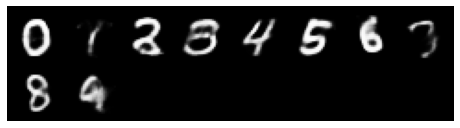

In [13]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import matplotlib.animation as animation
from IPython.display import HTML

fig = plt.figure(figsize=(8, 8))
plt.axis("off")
ims = [[plt.imshow(img.imread('results_CVAE/sample_' + str(epoch) + '.png'), animated=True)] for epoch in range(1, 51)]
ani = animation.ArtistAnimation(fig, ims, interval=600, repeat_delay=600, blit=True)

HTML(ani.to_jshtml())